# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv

from hnc.hnc.PIE import Plasma_of_Ions_and_Electrons as PLASMA

from hnc.hnc.constants import *
from hnc.hnc.misc import n_from_rs, rs_from_n

from pandas import read_csv

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
                
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}

</style>
""")


# Function that sets up HNC QSP 

### Create and run plasma

In [2]:
name='H'
Z, A = 1, 1
mi = m_p * A
  
ni_cc = 5.98e23
ri_cm = rs_from_n(ni_cc)
ri_AU = ri_cm*cm_to_AU

Te_eV = 2
Ti_eV = 2

ri_AU
Zbar = 1

### Make βu_ii, βu_fi from using bound density from AA
If we assume the bound state does not deform at all, then we can calculate potentials based on it easily via integration

### Solving

In [3]:
from scipy.optimize import least_squares
from scipy.interpolate import interp1d

def custom_flat(hnc_matrix):
    hnc_flat = np.concatenate([hnc_matrix[0,0],hnc_matrix[0,1],hnc_matrix[1,1]])
    return hnc_flat

def custom_unflat(hnc_flat):
    hnc00, hnc01, hnc11 = np.split(hnc_flat,3)
    hnc_matrix = np.zeros((2,2,len(hnc00)))
    hnc_matrix[0,0] = hnc00
    hnc_matrix[1,0] = hnc01
    hnc_matrix[0,1] = hnc01
    hnc_matrix[1,1] = hnc11
    return hnc_matrix

def solve_least_squares(plasma, sparse_k_array, c_s_k_guess=None, ftol=1e-8):
    if c_s_k_guess is None:
        c_s_k_guess = plasma.hnc.c_s_k_matrix

    # Create functions for converting between sparse, not sparse and flattened versions of c_s_k
    get_sparse_csk = lambda c_s_k_flat: np.concatenate([interp1d(plasma.hnc.k_array, c_s_k)(sparse_k_array) for c_s_k in np.split(c_s_k_flat,3) ])
    get_csk = lambda sparse_hnc_csk: interp1d(sparse_k_array, sparse_hnc_csk, kind='cubic')(plasma.hnc.k_array)
    get_csk_matrix_from_sparse_csk_flat =  lambda sparse_c_s_k_flat: custom_unflat(np.concatenate([get_csk(sparse_csk) for sparse_csk in np.split(sparse_c_s_k_flat,3)]))
    
    def min_function(sparse_c_s_k_flat):
        c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sparse_c_s_k_flat)
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        plasma.hnc.c_s_k_matrix = new_c_s_k_matrix.copy()
        new_c_s_k_flat = custom_flat(new_c_s_k_matrix)
        return sparse_c_s_k_flat - get_sparse_csk(new_c_s_k_flat)
    
    c_s_k_flat_guess = custom_flat(c_s_k_guess)
    c_s_k_sparse_guess = get_sparse_csk(c_s_k_flat_guess)
    sol = least_squares(min_function, c_s_k_sparse_guess, verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    plasma.hnc.c_s_k_matrix = get_csk_matrix_from_sparse_csk_flat(sol.x)
    plasma.hnc.set_all_matrices_from_csk(plasma.hnc.c_s_k_matrix)
    print(sol)

def best_shift(plasma, guess_c_s_k, ftol=1e-8, set=True):
    
    def min_function(multiplier_list):
        xii, xei, xee = multiplier_list
        multiplier_matrix = np.array([[xii,xei],[xei,xee]])
        c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * guess_c_s_k
        new_c_s_k_matrix = plasma.hnc.guess_c_s_k_matrix(c_s_k_matrix)
        
        return c_s_k_matrix.flatten() - new_c_s_k_matrix.flatten()
    
    sol = least_squares(min_function, np.ones((3)) , verbose=2, ftol=ftol)#, bounds = c_s_k_bounds)
    xii, xei, xee = sol.x
    multiplier_matrix = np.array([[xii,xei],[xei,xee]])
    
    plasma.hnc.c_s_k_matrix = multiplier_matrix[:,:,np.newaxis] * guess_c_s_k
    print(sol)
    return sol

In [13]:
def make_Improved_Kelbg_βvei(atom, γ=None):
    if γ is None:
        x1 = np.sqrt(8*π*self.Tie_c)
        a_ep = 1.09
        γ = (x1 + x1**2)/( 1 + a_ep*x1 + x1**2)
        
    βvei = atom.qsp.βv_Improved_Kelbg(atom.qsp.Γei, atom.hnc.r_array, atom.qsp.Λei, γ=γ ) 
    βvee = atom.qsp.βv_Improved_Kelbg(atom.qsp.Γee, atom.hnc.r_array, atom.qsp.Λee, γ=1 ) + atom.qsp.βv_Pauli(atom.hnc.r_array)
    
    atom.hnc.βu_r_matrix[0,1] = βvei
    atom.hnc.βu_r_matrix[1,0] = βvei
    atom.hnc.βu_r_matrix[1,1] = βvee
    
    atom.hnc.set_βu_matrix(atom.hnc.βu_r_matrix)


In [73]:
def plasma_f(γ, closure='svt'):
    plasma = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=False,
             βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
             qsp_options = {'Te_c_type':'VMC'},
             hnc_options={'kappa_multiscale':10, 'R_max':20,'N_bins':2000,'oz_method':closure},
             hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':100},
             root_options={'options':{'maxfev':100,'xtol':1e-14}})
    
    make_Improved_Kelbg_βvei(plasma, γ=γ)
    return plasma

In [74]:
γ_list = [0.9,1,2]

plasma_list = []
for γ in γ_list:
    plasma = plasma_f(γ, closure='svt')
    plasma.run_hnc()
    plasma_list.append(plasma)

Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 1.848e+00
Starting Ng loop, using best index so far:  99
Exiting status 0, reverting to best index so far: 105
Final iter:108, Total Error: 4.030e-10
Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 1.850e+00
Starting Ng loop, using best index so far:  99
Exiting status 0, reverting to best index so far: 104
Final iter:107, Total Error: 3.917e-09
Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 1.852e+00
Starting Ng loop, using best index so far:  99
Exiting status 0, reverting to best index so far: 105
Final iter:108, Total Error: 2.383e-10


In [72]:
for plasma in [ plasma_list[0]]:
    solve_least_squares(plasma, np.linspace(plasma.hnc.k_array[0], plasma.hnc.k_array[-1], num=200))

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3613e+10                                    2.92e+14    
       1              2         2.5994e+03      2.36e+10       1.11e+01       4.68e+04    
       2              5         1.1889e+03      1.41e+03       1.38e+00       6.61e+03    
       3              9         1.0302e+03      1.59e+02       2.16e-02       4.41e+03    
       4             10         9.0519e+02      1.25e+02       4.33e-02       8.41e+03    



KeyboardInterrupt



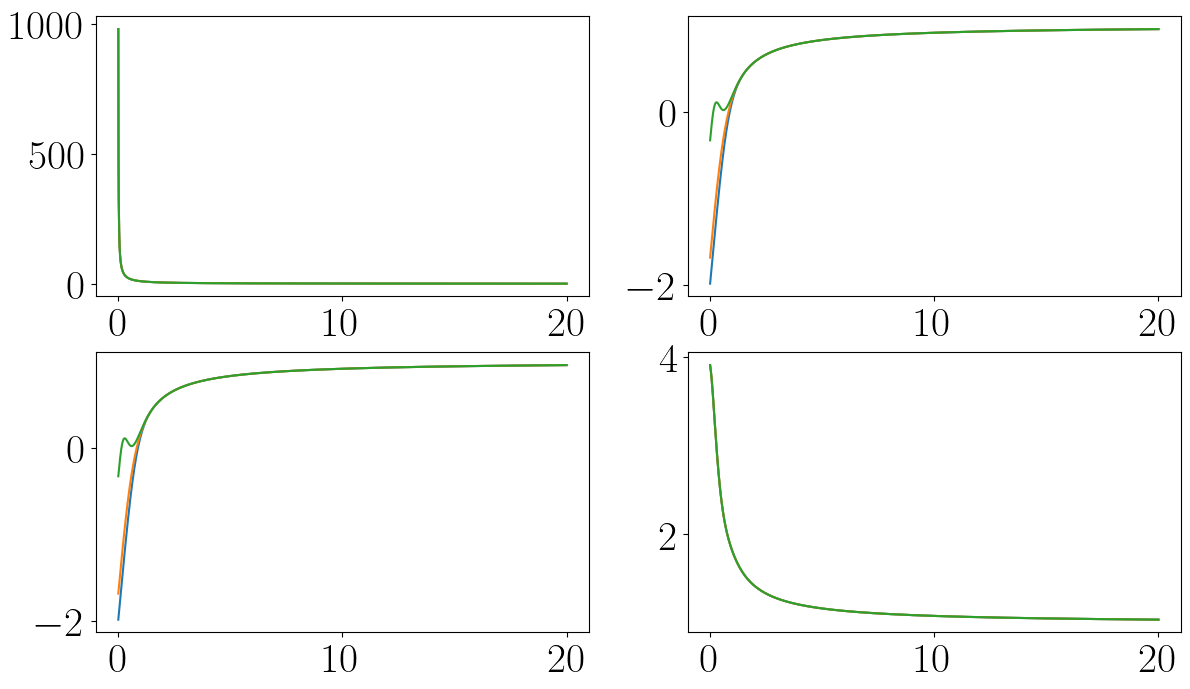

In [87]:
fig, axs = plt.subplots(2,2, figsize=(14,8))

for γ, plasma in zip(γ_list,plasma_list):
    for i in range(2):
        for j in range(2):
            axs[i,j].plot(plasma.hnc.r_array, plasma.hnc.βu_r_matrix[i,j]+1, label=r"$\gamma$ = {0}".format(γ))

### Plot and Comparison to QMD

In [75]:
ocp =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=False,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
ocp.run_ocp_hnc();
yp =  PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar, find_βuee=False,
                 βu_options = {'add_bridge':True,'bridge':'yukawa', 'pseudopotential':False}, 
                 hnc_options={'kappa_multiscale':10, 'R_max':10,'N_bins':1000,'oz_method':'standard'},
                 hnc_solve_options={'num_iterations':10000,'alpha_Picard':0.1, 'verbose':False,'iters_to_wait':500},
                 root_options={'options':{'maxfev':100,'xtol':1e-14}})
yp.run_yukawa_hnc();

Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 5.246e+00
Starting Ng loop, using best index so far:  499
Exiting status 0, reverting to best index so far: 500
Final iter:503, Total Error: 7.086e-09
Te_in_eV: 2.000
Ti_in_eV: 2.000
0: Initial condition Total Error: 3.490e+01
Exiting status 0, reverting to best index so far: 435
Final iter:436, Total Error: 9.936e-09


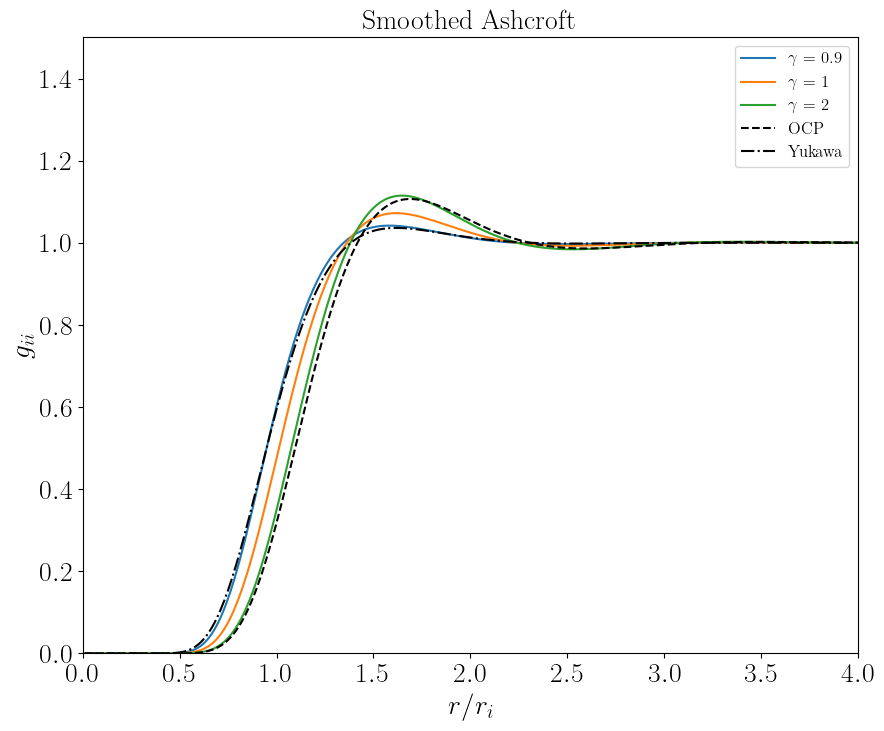

In [76]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Smoothed Ashcroft", fontsize=20)

for γ, plasma in zip(γ_list,plasma_list):
    ax.plot(plasma.hnc.r_array, plasma.hnc.h_r_matrix[0,0]+1, label=r"$\gamma$ = {0}".format(γ))

# OCP
ax.plot(ocp.ocp_hnc.r_array, ocp.ocp_hnc.h_r_matrix[0,0]+1,'k--', label='OCP')
ax.plot(yp.yuk_hnc.r_array, yp.yuk_hnc.h_r_matrix[0,0]+1,'k-.', label='Yukawa')
# ax.plot(custom.ocp_hnc.r_array, custom.ocp_hnc.h_r_matrix[0,0]+1,'g-.', label=r'$\Gamma_{ii}/r^{1.4}$')
# ax.plot(custom2.ocp_hnc.r_array, custom2.ocp_hnc.h_r_matrix[0,0]+1,'b-.', label=r'$\Gamma_{ii}/r^{0.8}$')


# Plotting functions
# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(0,4)
ax.set_ylim(0,1.5)
ax.set_ylabel(r'$g_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_yscale('symlog', linthresh=2)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=12, loc='upper right')


In [78]:
from scipy.signal import find_peaks

def get_peaks(hnc):
    peak_locs = [
        hnc.r_array[index] for index in find_peaks(np.abs(hnc.h_r_matrix[0,0]))[0]]
    first_peak_index = np.argmin(np.abs(np.array(peak_locs)-1.5))
    second_peak_index = np.argmin(np.abs(np.array(peak_locs)-2.2))
    third_peak_index = np.argmin(np.abs(np.array(peak_locs)-3.2))
    return [peak_locs[index] for index in [first_peak_index,second_peak_index,third_peak_index]]

print(get_peaks(plasma.hnc))

for hnc in [ocp.ocp_hnc]:
    print(get_peaks(hnc))

[1.6500000000000001, 2.5300000000000002, 3.4]
[1.69, 2.6, 3.5]



### Plot S(k)

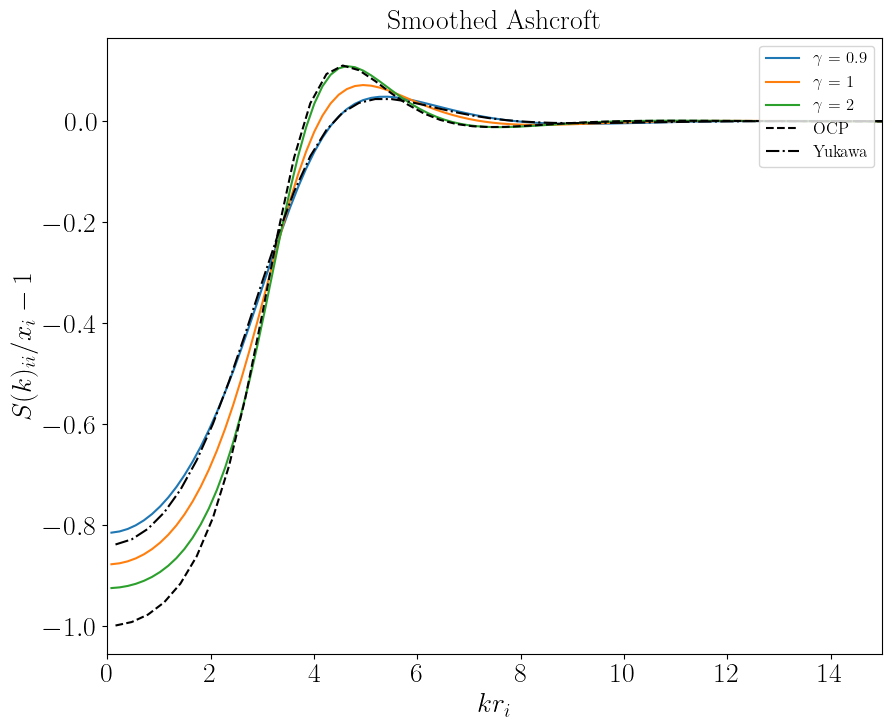

In [79]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set_title("Smoothed Ashcroft", fontsize=20)

for γ, plasma in zip(γ_list,plasma_list):
    ax.plot(plasma.hnc.k_array, np.sum(plasma.hnc.rho)/plasma.hnc.rho[0]*plasma.hnc.S_k_matrix[0,0]-1, label=r"$\gamma$ = {0}".format(γ))



# OCP
ax.plot(ocp.ocp_hnc.k_array, np.sum(ocp.ocp_hnc.rho)/ocp.ocp_hnc.rho[0]*ocp.ocp_hnc.S_k_matrix[0,0]-1,'k--', label='OCP')
ax.plot(yp.yuk_hnc.k_array, np.sum(yp.yuk_hnc.rho)/yp.yuk_hnc.rho[0]*yp.yuk_hnc.S_k_matrix[0,0]-1,'k-.', label='Yukawa')
# ax.plot(custom.ocp_hnc.r_array, custom.ocp_hnc.h_r_matrix[0,0]+1,'g-.', label=r'$\Gamma_{ii}/r^{1.4}$')
# ax.plot(custom2.ocp_hnc.r_array, custom2.ocp_hnc.h_r_matrix[0,0]+1,'b-.', label=r'$\Gamma_{ii}/r^{0.8}$')

# Data
# ax.plot(MD_data['r'], MD_data['g'], 'k',label='VASP')

# Plotting functions
# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(0,15)
# ax.set_ylim(0,2)
ax.set_ylabel(r'$S(k)_{ii}/x_i-1$',fontsize=20)
ax.set_xlabel(r'$k r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
# ax.set_yscale('symlog', linthresh=0.1)

# [i.set_linewidth(0.1) for i in ax.spines.itervalues()]
ax.legend(fontsize=12, loc='upper right')



### Effective Potential

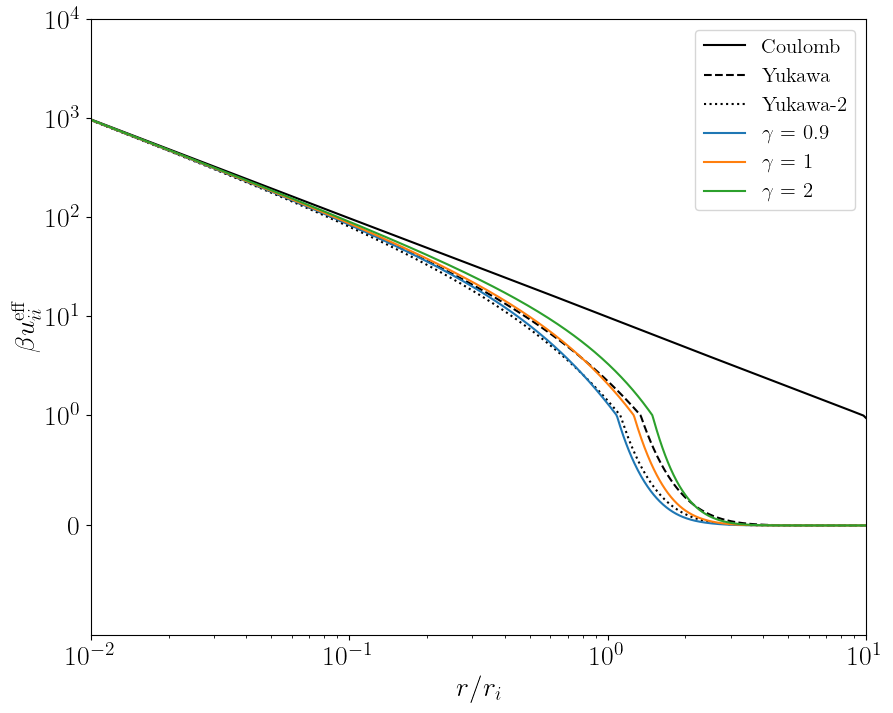

In [80]:
# Luke_pair = read_csv("../data/Al_T1_tab.lammps.PAIR", delim_whitespace=True, header=4)


fig, ax = plt.subplots(figsize=(10,8))

# LUKE Potfit VASP
# ax.plot(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU, plasma.qsp.βie_c*Luke_pair['u[eV]']*eV_to_AU, 'k-.',label='Force Matched VASP')
# ax.plot(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU, 1/(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU)**4.25, 'k:',label='Force Matched VASP')
# Coulomb and Yukawa
yp.yuk_hnc.invert_HNC_OZ([])
# custom.ocp_hnc.invert_HNC_OZ([])
ax.plot(plasma.hnc.r_array, plasma.hnc.βu_r_matrix[0,0],'k-', label='Coulomb')
ax.plot(plasma.hnc.r_array, plasma.qsp.βv_Yukawa(plasma.hnc.r_array),'k--', label='Yukawa')
ax.plot(yp.yuk_hnc.r_array, yp.yuk_hnc.βueff_r_matrix[0,0],'k:', label='Yukawa-2')

for γ, plasma in zip(γ_list,plasma_list):
    plasma.hnc.invert_HNC_OZ([1])
    ax.plot(plasma.hnc.r_array, plasma.hnc.βueff_r_matrix[0,0], label=r"$\gamma$ = {0}".format(γ))

# ax.set_title(r"$R_c = {}$".format(Rc),fontsize=20)
ax.set_xlim(1e-2,10)
ax.set_ylim(-1,1e4)
ax.set_ylabel(r'$\beta u^{\text{eff}}_{ii}$',fontsize=20)
ax.set_xlabel(r'$r/r_i$ ',fontsize=20)
ax.tick_params(labelsize=20)
ax.set_yscale('symlog', linthresh=1)
ax.set_xscale('log')
# ax.set_yscale('log')

ax.legend(fontsize=15)

In [ ]:
# np.savetxt("Al1_βu_eff_raw.txt", np.array([plasma_list[2].hnc.r_array,plasma_list[2].hnc.βueff_r_matrix[0,0] ]).T, header='r/r_i 			 βuii_eff(r/r_i)')
# np.savetxt("Al1_g_r_raw.txt", np.array([plasma_list[2].hnc.r_array,plasma_list[2].hnc.h_r_matrix[0,0]+1, plasma_list[2].hnc.h_r_matrix[1,0]+1,plasma_list[2].hnc.h_r_matrix[1,1]+1 ]).T, header='r/r_i 				 gii(r/r_i) 				 gie(r/r_i) 				 gee(r/r_i)')

#### Save DCF

In [ ]:
# np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_oz-hnc-Pauli-bound-dist_c_k_matrix.csv", atom1.hnc.c_k_matrix.reshape(4,atom1.hnc.N_bins))
# np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_svt-hnc-softAshcroft-Rc0p2_c_k_matrix.csv", atom2.hnc.c_k_matrix.reshape(4,atom2.hnc.N_bins))
# np.savetxt(f"/home/zach/plasma/hnc/TCCW/data/dcf_data/{name}_{Ti_eV:0.2e}eV_rs{ri_AU:0.3f}_svt-hnc-Pauli-bound-point_c_k_matrix.csv", atom3.hnc.c_k_matrix.reshape(4,atom3.hnc.N_bins))

### Bound and Free state Examination

(0.75397, 0.4313508217941639, -0.0013116715803434512, 0.276851714010801)

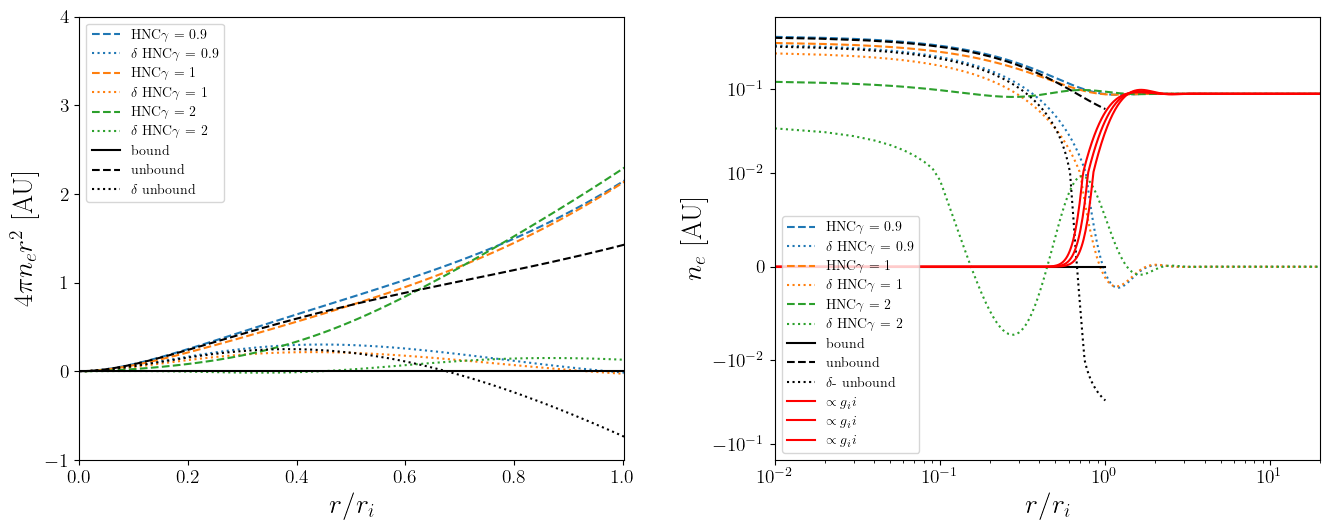

In [81]:
from scipy.integrate import simpson

ne_bar = Zbar*plasma.qsp.ni
bound_file = "../data/GP_H1.dat"
AA_data = read_csv(bound_file, delim_whitespace=True, header=0)
AA_r_AU_full = AA_data['r']
AA_nb_AU_full = AA_data['ne_b']
AA_nub_AU_full = AA_data['ne_s']


# Plot bound states
fig, axs = plt.subplots(1,2, figsize=(14,6))


# Model Comparison
for i, (γ, plasma) in enumerate(zip(γ_list,plasma_list)):
    nb_hnc = (plasma.hnc.h_r_matrix[0,1]+1)*ne_bar
    δnb_hnc = (plasma.hnc.h_r_matrix[0,1])*ne_bar
    r_hnc = plasma.hnc.r_array*plasma.qsp.ri

    ax.plot(plasma.hnc.r_array, plasma.hnc.βueff_r_matrix[0,0], label=r"$\gamma$ = {0}".format(γ))
    axs[0].plot(plasma.hnc.r_array, 4*π*r_hnc**2*nb_hnc,'--', label = 'HNC'+r"$\gamma$ = {0}".format(γ),color=colors[i])
    axs[0].plot(plasma.hnc.r_array, 4*π*r_hnc**2*δnb_hnc,':' ,label = r'$\delta$ HNC'+r"$\gamma$ = {0}".format(γ),color=colors[i])
    axs[1].plot(plasma.hnc.r_array, nb_hnc,'--', label='HNC'+r"$\gamma$ = {0}".format(γ),color=colors[i])
    axs[1].plot(plasma.hnc.r_array, δnb_hnc,':', label=r'$\delta$ HNC'+r"$\gamma$ = {0}".format(γ),color=colors[i])


# atoMEC
axs[0].set_ylabel(r'$4 \pi n_e r^2$ [AU]', fontsize=20)
axs[0].plot(AA_r_AU_full/plasma.qsp.ri, 4*π*AA_nb_AU_full*AA_r_AU_full**2,'k-', label='bound')
axs[0].plot(AA_r_AU_full/plasma.qsp.ri, 4*π*AA_nub_AU_full*AA_r_AU_full**2,'k--', label='unbound')
axs[0].plot(AA_r_AU_full/plasma.qsp.ri, 4*π*(AA_nub_AU_full-ne_bar)*AA_r_AU_full**2,'k:' ,label=r'$\delta$ unbound')
# axs[0].plot(AA_r_AU_full/plasma.qsp.ri, 4*π*AA_ntb_AU_full*AA_r_AU_full**2, label='tightly bound (<-10 AU)')
axs[0].set_ylim(-1, 4)
axs[0].set_xlim(0, np.max(AA_r_AU_full/plasma.qsp.ri))

axs[1].set_ylabel(r'$n_e$ [AU]', fontsize=20)
axs[1].plot(AA_r_AU_full/plasma.qsp.ri, AA_nb_AU_full,'k-', label='bound')
axs[1].plot(AA_r_AU_full/plasma.qsp.ri, AA_nub_AU_full,'k--', label='unbound')
axs[1].plot(AA_r_AU_full/plasma.qsp.ri, AA_nub_AU_full-ne_bar,'k:', label=r'$\delta$- unbound')
# axs[1].plot(AA_r_AU_full/plasma.qsp.ri, AA_ntb_AU_full, label='tightly bound (<-10 AU)')
axs[1].set_xscale('log')
axs[1].set_yscale('symlog',linthresh=1e-2)
axs[1].set_xlim(1e-2, plasma.hnc.r_array[-1])
# axs[1].set_ylim(-0.1,0.1)

for γ, plasma in zip(γ_list,plasma_list):
    axs[1].plot(plasma.hnc.r_array, (plasma.hnc.h_r_matrix[0,0]+1)*ne_bar, 'r-', label=r"$\propto g_ii$")

for ax in axs:
    # ax.axvspan(AA_r_AU_full[0]/plasma.qsp.ri, min_r_to_use/plasma.qsp.ri, color='k', alpha=0.1)
    ax.set_xlabel(r'$r/r_i$', fontsize=20)
    # ax.set_xlim(np.min(AA_r_AU_full/plasma.qsp.ri), np.max(AA_r_AU_full/plasma.qsp.ri))
    ax.legend(fontsize=10)
    ax.tick_params(labelsize=14)
plt.tight_layout()

AA_r_AU_full[915],r_hnc[30], simpson((4*π*r_hnc**2*δnb_hnc)[:30], x=r_hnc[:30]), simpson(4*π*(AA_nub_AU_full*AA_r_AU_full**2)[:915],  AA_r_AU_full[:915])

In [82]:
# Model Comparison
nb_hnc = (plasma.hnc.h_r_matrix[0,1]+1)*ne_bar
δnb_hnc = (plasma.hnc.h_r_matrix[0,1])*ne_bar
r_hnc = plasma.hnc.r_array*plasma.qsp.ri

print(simpson(4*π*r_hnc**2*nb_hnc,r_hnc), simpson(4*π*r_hnc**2*δnb_hnc,r_hnc))
print(simpson(4*π*AA_nub_AU_full*AA_r_AU_full**2,AA_r_AU_full))

8000.074904034627 0.0749050346273209
0.9927041963890109


In [58]:
np.sqrt(simpson(AA_nb_AU_full*AA_r_AU_full**4,AA_r_AU_full)/simpson(AA_nb_AU_full*AA_r_AU_full**2,AA_r_AU_full))/ri_AU

/tmp/ipykernel_65140/475249818.py:1: RuntimeWarning: invalid value encountered in scalar divide
  np.sqrt(simpson(AA_nb_AU_full*AA_r_AU_full**4,AA_r_AU_full)/simpson(AA_nb_AU_full*AA_r_AU_full**2,AA_r_AU_full))/ri_AU


nan

# Transport
## Born Green Viscocity
See [Morioka 2004](https://www.sciencedirect.com/science/article/pii/S0022309304003692)

\begin{align}
η = f_{BG} \frac{2 \pi}{15} \left(\frac{M}{RT} \right)^{1/2} \frac{n^2}{N_a} \int^\infty_0 g(r) \frac{d\phi}{dr}r^4 dr
\end{align}
Resulting units is Pa s


In [ ]:
from scipy.integrate import simpson

def get_ηBG(plasma, plot=False):
    plasma.hnc.invert_HNC_OZ([1])
    fBG = -1
    n_AU = n_from_rs(plasma.qsp.ri)
    r_array = plasma.hnc.r_array*plasma.qsp.ri
    gii = plasma.hnc.h_r_matrix[0,0]+1
    dφdr = plasma.qsp.Ti*np.gradient(plasma.hnc.βueff_r_matrix[0,0], r_array)

    integrand = r_array**4 * gii * dφdr
    if plot==True:
        fig, ax = plt.subplots()
        ax.plot(r_array, dφdr*r_array**4)
    
    integral = simpson(integrand, x=r_array)
    η = fBG* 2*π/15 * (plasma.qsp.βi*plasma.qsp.m_i)**0.5*n_AU**2*integral
    return η

# Model Comparison
for i, ( line, params, plasma) in enumerate(zip(line_list, params_list, plasma_list)):
    α, Rc = params
    η_SI = get_ηBG(plasma)*AU_to_Pa*AU_to_s # Pa s = kg m^-1 s^-1 
    print(f"α={α}, Rc={Rc}")
    # print(f"\tSI: η = {η_SI:0.3e} [kg m^-1 s^-1] (or [Pa s])")
    η_cgs = η_SI * 1000/100 # g cm^-1 s^-1
    print(f"\tCGS: η = {η_cgs:0.3e} [g cm^-1 s^-1]")

In [ ]:
Zbar_list  = np.linspace(3,Zbar, num=100)
# Zbar_list = [1,3]
atom_list= []
for i, Zbar_i in enumerate(Zbar_list):
    print("Zbar = {0:.3f}".format( Zbar_i ))
    
    atom = PLASMA(Z, A, ni_cc, Ti_eV, Te_eV, Zbar=Zbar_i, 
                 βu_options = {'add_bridge':True}, 
                 qsp_options={'r_c':0},
                 hnc_options={'kappa_multiscale':10},
                 hnc_solve_options={'alpha_Picard':0.5})
    if i>=1:
        Z2_matrix = [[Zbar_list[i]]]
        # guess_2 = 
        c_s_k_guess = atom_list[-1].hnc.c_s_k_matrix
        c_s_k_guess[0,0] *= (Zbar_list[i]/Zbar_list[i-1])**2 
        c_s_k_guess[0,1] *= (Zbar_list[i]/Zbar_list[i-1])**1 
        c_s_k_guess[1,0] *= (Zbar_list[i]/Zbar_list[i-1])**1
#         c_s_k_guess[0,0] *= 0
    else:
        c_s_k_guess *=0
    atom.run_hnc(c_s_k_guess=c_s_k_guess)
    atom_list.append( atom )

In [ ]:
fig, axs = plt.subplots(2, 2, facecolor='w', figsize=(10,8) )

atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix-atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 
atom3_guess = atom2.hnc.c_s_k_matrix + (atom2.hnc.c_s_k_matrix/atom1.hnc.c_s_k_matrix)/(2-1)*(3-2) 

for i in range(2):
    for j in range(2):
        for k, atom in enumerate(atom_list):
            color = plt.cm.viridis(k/len(atom_list))
            Z_factor = (Zbar_list[0]/Zbar_list[k])**-1
            axs[i, j].plot(atom.hnc.r_array, atom.hnc.c_s_k_matrix[i,j], '--',label= "Zbar", color= color)
            axs[i, j].plot(atom.hnc.r_array, Z_factor*atom_list[0].hnc.c_s_k_matrix[i,j],'.', label= "Zbar", color= color)
#             axs[i, j].plot(atom.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=2")
#             axs[i, j].plot(atom.hnc.r_array, atom6.hnc.c_s_k_matrix[i,j], label= "Zbar=6")
#         axs[i, j].plot(atom2.hnc.r_array, atom2.hnc.c_s_k_matrix[i,j]-atom1.hnc.c_s_k_matrix[i,j], label= "Zbar=2/1")
#         axs[i, j].plot(atom2.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j]-atom2.hnc.c_s_k_matrix[i,j], label= "Zbar=3/2")
#         axs[i, j].plot(atom2.hnc.r_array, atom3_guess[i,j] , 'k--', label= "Zbar=3 (guess)")
        
#         axs[i, j].plot(atom3.hnc.r_array, atom3.hnc.c_s_k_matrix[i,j],'k', label= "Zbar=3")
#         axs[i, j].plot(atom100.hnc.r_array, atom80.hnc.c_s_k_matrix[i,j]-100/80*atom100.hnc.c_s_k_matrix[i,j], label= "80/100 eV")
#         axs[i, j].plot(atom100.hnc.r_array, atom60.hnc.c_s_k_matrix[i,j], label= "60 eV")
         
#         axs[i, j].plot(atom100.hnc.r_array, T_rescale[i,j]*atom100.hnc.c_s_k_matrix[i,j], label= "rescaled 100 eV")
        
        axs[i,j].set_xscale('log')
#         axs[i, j].set_yscale('symlog', linthresh=0.1)
#         axs[i, j].legend()
        
plt.tight_layout()

In [ ]:
atom.get_cp(ε_derivative=1e-6, ε_table=1e-1, N_table= 2 )

In [ ]:
fig, ax = plt.subplots()

# ax.plot(atom.hnc.r_array, atom.hnc.βueff_r_matrix[0,0])
ax.plot(atom.hnc.r_array, atom.hnc.h_r_matrix[0,0]+1)
# ax.set_yscale('symlog', linthresh=1)

###### Hydrogen H1

c_p = 1.667e+08 [J/m^3/K] = 1.667e+09 [erg/cc/K]


c_p^ideal = 2.064e+07 [J/m^3/K] = 2.064e+08 [erg/cc/K]

c_v = 1.229e+08 [J/m^3/K] = 1.229e+09 [erg/cc/K]


γ = cp/cv = 1.357e+00

###### Aluminum Al1

c_p = 5.560e+06 [J/m^3/K] = 5.560e+07 [erg/cc/K]

c_p^ideal = 2.081e+06 [J/m^3/K] = 2.081e+07 [erg/cc/K]

c_v = 3.559e+06 [J/m^3/K] = 3.559e+07 [erg/cc/K]

c_p_over_nkB = 6.678

c_v_over_nkB = 4.275

γ = cp/cv = 1.562e+00

##### Carbon C1

c_p = 1.005e+09 [J/m^3/K] = 1.005e+10 [erg/cc/K]

c_p^ideal = 1.729e+07 [J/m^3/K] = 1.729e+08 [erg/cc/K]

c_v = 7.410e+08 [J/m^3/K] = 7.410e+09 [erg/cc/K]

γ = cp/cv = 1.357e+00

##### Copper Cu1
c_p = 6.829e+07 [J/m^3/K] = 6.829e+08 [erg/cc/K]

c_p^ideal = 2.930e+06 [J/m^3/K] = 2.930e+07 [erg/cc/K]

c_v = 4.460e+07 [J/m^3/K] = 4.460e+08 [erg/cc/K]

γ = cp/cv = 1.531e+00

In [ ]:
# Compare to Ichimaru
n_AU = ni_cc * (1e2*aB)**3
E_over_nkBT = atom.U/( Te*N )
P_over_nkBT = atom.P/(Te*n_AU)
c_p_over_nkB = C_p_AU/N #c_p_SI_vol/k_B/(ni_cc*1e6)
E_over_nkBT, P_over_nkBT, c_p_over_nkB  

In [ ]:
# 2x2
#(16.078004224152146, 7.958852940677674, 20.391840227664225)
# 3x3
#(17.29156071613095, 9.41653222069282, 19.954770080816058)
# 4x4
#(17.29156071613095, 9.41653222069282, 20.31577883096223)
# 6x6
#(17.29156071613095, 9.41653222069282, 20.341775951597302)



In [ ]:
#cp units are J/K/m^3

In [ ]:
c_p_SI_vol *J_to_erg*1e-6 # from J/K/m^3 to erg/K/cc

In [ ]:
(c_p_over_nkB*ni_cc * k_B*1e6)/1e8 # in erg/

In [ ]:
# Ideal
# (1.503495387998133, 1.0020009999999997, 2.5033223241241656)


# βu_eff matching

In [ ]:
from pandas import read_csv
from scipy.interpolate import interp1d
# luke_file = '/home/zach/plasma/atomic_forces/data/Al_T0p5_tab.lammps.PAIR'
luke_file = '/home/zach/plasma/atomic_forces/data/Al_T1_tab.lammps.PAIR'

luke_data = read_csv(luke_file ,delim_whitespace=True,header=3, names=['r [A]','V [eV]','F [eV/A]'])
# luke_r, luke_βV = 1e-10/aB/r_s*luke_data['r [A]'], 1/(Te/eV)*luke_data['V [eV]']
luke_r, luke_βV = 1e-8/ri_AU*luke_data['r [A]'], 1/(Te_eV)*luke_data['V [eV]']
luke_βV_function = interp1d(luke_r, luke_βV,fill_value='extrapolate',bounds_error=False)

In [ ]:
from scipy.optimize import curve_fit

class βu_fit():
    def __init__(self, func, r_array, y_data, initial_guess):
        self.r = r_array
        self.y = y_data
        self.y_vals = curve_fit(func, r_array, y_data, maxfev=int(1e5), p0=initial_guess)
        self.y_fit  = func(r_array, *self.y_vals[0])
        self.err = np.linalg.norm(self.y_fit-self.y)
        print(func.__name__ + " error: {0:.3e} ".format(self.err))

def yukawa(r, Γ, κ):
    return  Γ/r*np.exp(-κ*r)

def yukawa_plus(r, a, b, c, d):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d)))

def yukawa_plus_gaussian(r, a ,b ,c, d ,e, f, g):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.exp(-(f-r)**2/g)

def yukawa_plus_cos(r, a ,b ,c, d , h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + h*np.cos((r-i)*j*np.exp(-k*r))*np.exp(-l*r)

def yukawa_plus_gaussian_cos(r, a ,b ,c, d ,e, f, g, h, i, j, k, l):
    return  a/r*np.exp(-b*r)/(1+np.exp(c*(r-d))) + e*np.cos((r-f)*g*np.exp(-h*r))*np.exp(-i*r) + j*np.exp(-(k-r)**2/l)


In [ ]:
atom, atomqsp = plasma.hnc, plasma.qsp

In [ ]:
atom.invert_HNC_OZ([1])
fit1 = βu_fit(yukawa, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ()])
try: 
    fit2 = βu_fit(yukawa_plus_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit1.y_vals[0], 1, 0.01, 1 , 10, 2])
except:
    pass
try:
    fit3 = βu_fit(yukawa_plus_gaussian_cos, atom.r_array, atom.βueff_r_matrix[0,0], initial_guess=[  *fit2.y_vals[0], -1, 1.9, 1])
except:
    pass

In [ ]:
from hnc.hnc.misc import P_Ideal_Fermi_Gas

fig, ax = plt.subplots(figsize=(10,8),facecolor='w')
# fig.suptitle(r"{0} $T=${1:.1f} eV, $r_i$={2:.2f}".format(case_id, Te/eV, atomqsp.ri), fontsize=20)

#Compare to Yukawa and Coulomb
coulomb_matrix = (atom.Γ_matrix[:,:,np.newaxis]/atom.r_array) [:-1,:-1]

ax.plot(atom.r_array, atom.βu_r_matrix[0,0], 'k--',label='Initial')
ax.plot(plasma.hnc.r_array, plasma.qsp.βv_Yukawa(plasma.hnc.r_array),'k--', label='Yukawa')

# Plot effective potential and fit
for i, plasma in enumerate(plasma_list):
    if i>2:
        continue
    fit = βu_fit(yukawa, atom.r_array, plasma.hnc.βueff_r_matrix[0,0], initial_guess=[   atomqsp.Γii, atomqsp.get_κ()])
    ax.plot(atom.r_array, plasma.hnc.βueff_r_matrix[0,0],color=colors[i], label= r"$\beta u^{\text{eff}}_{ii}$")    
    ax.plot(fit.r, fit.y_fit, color=colors[0],linestyle='--',label=r"$\beta u^{\text{eff}}_{ii}$ Yukawa Fit")




# LUKE Potfit VASP
ax.plot(Luke_pair['r[A]']*Angstrom_to_AU/ri_AU, plasma.qsp.βie_c*Luke_pair['u[eV]']*eV_to_AU, 'r-.',label='Force Matched VASP')

ax.tick_params(labelsize=20)
ax.set_xlabel(r"$r/r_s$",fontsize=20)
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)

ax.set_xlim(1e-2, 3)
# ax.set_xscale('log')
ax.set_yscale('symlog',linthresh=1)
# ax.set_yscale('log')
# ax.set_ylim(np.min([-10, 2*np.min(atom.βueff_r_matrix[0,0])]), np.max([1e3, 2*np.max(atom.βueff_r_matrix[0,0])]))
ax.set_ylim(-1e0,1e3)
ax.tick_params(labelsize=15)
ax.legend(fontsize=10)


fig.tight_layout()